In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [5]:
from deep_boltzmann.models import DoubleWell
from deep_boltzmann.networks.invertible import create_NICERNet, create_RealNVPNet, invnet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [6]:
def test_sample(network, temperature=1.0, nsample=100000, plot=True):
    if nsample <= 100000:
        sample_z, sample_x, energy_z, energy_x, logw = network.sample(temperature=temperature, nsample=nsample)
    else:
        sample_x = []
        for i in range(int(nsample/100000)):
            _, sample_x_, _, _, _ = network.sample(temperature=temperature, nsample=nsample)
            sample_x.append(sample_x_)
        sample_x = np.vstack(sample_x)
        
    # xgen = network.Tzx.predict(np.sqrt(temperature) * np.random.randn(100000, 2))
    params = DoubleWell.params_default.copy()
    params['dim'] = 2
    double_well = DoubleWell(params=params)
    plt.figure(figsize=(4, 4))
    h, b = np.histogram(sample_x[:, 0], bins=100)
    bin_means = 0.5*(b[:-1] + b[1:])
    Eh = -np.log(h) / temperature
    if plot:
        Ex, E = double_well.plot_dimer_energy(temperature=temperature)
        Eh = Eh - Eh.min() + E.min()
        plt.plot(bin_means, Eh, color='green', linewidth=2)
    return bin_means, Eh

In [7]:
# reweighting
def test_sample_rew(network, temperature=1.0, plot=True):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=100000)
    log_w -= log_w.max()
    bin_means, Es = free_energy_bootstrap(sample_x[:, 0], -2.5, 2.5, 100, sample=100, weights=np.exp(log_w))
    plt.figure(figsize=(4, 4))
    Emean = mean_finite(Es, axis=0)-10.7
    Estd = std_finite(Es, axis=0)
    var = mean_finite(std_finite(Es, axis=0) ** 2)
    if plot:
        double_well.plot_dimer_energy()
        plt.errorbar(bin_means, Emean, Estd, linewidth=2, color='green')
    # variance
    print('Estimator Standard Error: ', np.sqrt(var))
    return bin_means, Emean, Estd

In [8]:
def hist_weights(network):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=100000)
    log_w -= log_w.max()
    bins = np.linspace(-2.5, 2.5, 100)
    bin_means = 0.5 * (bins[:-1] + bins[1:])
    sample_x_index = np.digitize(sample_x[:, 0], bins)
    whist = np.zeros(len(bins) + 1)
    for i in range(len(log_w)):
        whist[sample_x_index[i]] += np.exp(log_w[i])
    return bin_means, whist[1:-1]

In [9]:
def test_mcmc(network, nsample):
    fig, axes = plt.subplots(2, 1, figsize=(7, 7))
    # test sampling
    gp_mcmc = GaussianPriorMCMC(network)#, std_z=[0.7, 1.0])
    Z, X, E, J = gp_mcmc.run(nsample)
    print('Transitions:', count_transitions(X[:, 0], -1, 1))
    axes[0].plot(X[:min(10000, nsample), 0])
    # plot PMF
    h, b = np.histogram(X[:, 0], bins=100)
    b = 0.5 * (b[:-1] + b[1:])
    F = -np.log(h)
    Edimer = double_well.plot_dimer_energy(axes[1])
    axes[1].plot(b, F-F.min()+Edimer.min())

In [10]:
def plot_transformation_field_2d(transformer, bounds, ngrid=20, ):
    # build grid
    x_coarse_grid = np.linspace(bounds[0], bounds[1], num=ngrid)
    y_coarse_grid = np.linspace(bounds[2], bounds[3], num=ngrid)
    grid = []
    for i in range(len(x_coarse_grid)):
        for j in range(len(y_coarse_grid)):
            grid.append([x_coarse_grid[i], y_coarse_grid[j]])
    grid = np.array(grid)

    # compute transformation field
    grid_pred = transformer.predict(grid)

    # show field
    plt.figure(figsize=(5, 5))
    plt.quiver(grid[:, 0], grid[:, 1], grid_pred[:, 0], grid_pred[:, 1], units='width')

In [11]:
def getx(x):
    return x[:, 0]

Plotting function, sort of generic
-----

In [12]:
def plot_network(network, weight_cutoff=1e-2):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3.5))
    plt.subplots_adjust(wspace=0.25)
    # Plot X distribution
    axis = axes[0]
    axis.plot(traj_left[:, 0], traj_left[:, 1], linewidth=0, marker='.', markersize=3, color='blue')
    axis.plot(x_ts[:, 0], x_ts[:, 1], linewidth=0, marker='.', markersize=3, color='orange')
    axis.plot(traj_right[:, 0], traj_right[:, 1], linewidth=0, marker='.', markersize=3, color='red')
    axis.set_xlabel('$x_1$')
    axis.set_xlim(-3, 3)
    axis.set_ylabel('$x_2$', labelpad=-12)
    axis.set_ylim(-4, 4)
    axis.set_yticks([-4, -2, 0, 2, 4]);
    # Plot Z distribution
    axis = axes[1]
    z_left = network.transform_xz(traj_left)
    z_ts = network.transform_xz(x_ts)
    z_right = network.transform_xz(traj_right)
    axis.plot(z_left[:, 0], z_left[:, 1], linewidth=0, marker='.', markersize=3, color='blue')
    axis.plot(z_ts[:, 0], z_ts[:, 1], linewidth=0, marker='.', markersize=3, color='orange')
    axis.plot(z_right[:, 0], z_right[:, 1], linewidth=0, marker='.', markersize=3, color='red')
    circle = plt.Circle((0, 0), radius=1.0, color='black', alpha=0.4, fill=True)
    axis.add_artist(circle)
    circle = plt.Circle((0, 0), radius=2.0, color='black', alpha=0.25, fill=True)
    axis.add_artist(circle)
    circle = plt.Circle((0, 0), radius=3.0, color='black', alpha=0.1, fill=True)
    axis.add_artist(circle)
    axis.set_xlabel('$z_1$')
    axis.set_xlim(-4, 4)
    axis.set_ylabel('$z_2$', labelpad=-12)
    axis.set_ylim(-4, 4)
    axis.set_yticks([-4, -2, 0, 2, 4]);
    # Plot proposal distribution
    X1, Y1 = test_sample(network, temperature=1.0, plot=False);
    _, W1 = hist_weights(network)
    axis = axes[2]
    Ex, E = double_well.plot_dimer_energy(axis=axis, temperature=1.0)
    Y1 = Y1 - Y1.min() + E.min()
    Inan = np.where(W1 < weight_cutoff)
    Y1[Inan] = np.nan
    #Y2 = Y2 - Y2.min() + E.min()
    #axis.plot(X2, Y2, color='#FF6600', linewidth=2, label='ML+KL+RC')
    axis.plot(X1, Y1, color='orange', linewidth=2, label='ML+KL')
    axis.set_xlim(-3, 3)
    axis.set_ylim(-12, 5.5)
    axis.set_yticks([]);
    axis.set_xlabel('$x_1$')
    axis.set_ylabel('Energy / kT')
    #plt.legend(ncol=1, loc=9, fontsize=12, frameon=False)
    # Plot reweighted distribution
    RX1, RY1, DR1 = test_sample_rew(network, temperature=1.0, plot=False);
    axis = axes[3]
    Ex, E = double_well.plot_dimer_energy(axis=axis, temperature=1.0)
    RY1 = RY1 - RY1[np.isfinite(RY1)].min() + E.min()
    RY1[Inan] = np.nan
    #RY1[RY1 > -4] = np.nan
    #RY2 = RY2 - RY2[np.isfinite(RY2)].min() + E.min()
    #axis.errorbar(RX2, RY2, DR2, color='#FF6600', linewidth=2, label='ML+KL+RC')
    axis.errorbar(RX1, RY1, DR1, color='orange', linewidth=2, label='ML+KL')
    axis.set_xlim(-3, 3)
    axis.set_ylim(-12, 5.5)
    axis.set_yticks([-12, -10, -8, -6, -4, -2, 0, 2, 4]);
    axis.set_xlabel('$x_1$')
    axis.set_ylabel('')
    return fig, axes

In [13]:
def low_energy_fraction(energies, Emax):
    low_energy_count = [np.count_nonzero(E<Emax) for E in energies]
    sizes = [E.size for E in energies]
    low_energy_fraction = np.array(low_energy_count) / sizes
    return low_energy_fraction

In [14]:
def plot_convergence(hist_ML, hist_KL, enerx_cut, enerz_cut, MLcol=1, KLcol=2):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
    niter1 = len(hist_ML[0])
    niter2 = hist_KL[1].shape[0]
    niter = niter1 + niter2
    # ML loss
    losses_ML = np.concatenate([hist_ML[0], hist_KL[1][:, MLcol]])
    xticks = np.arange(niter1 + niter2) + 1
    axes[0].plot(xticks, losses_ML, color='black')
    axes[0].set_xlim(0, niter + 1)
    axes[0].set_ylabel('ML loss')
    axes[0].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # KL loss
    losses_KL = hist_KL[1][:, KLcol]
    xticks = np.arange(niter1, niter1 + niter2) + 1
    axes[1].plot(xticks, losses_KL, color='black')
    axes[1].set_xlim(0, niter + 1)
    axes[1].set_ylabel('KL loss')
    axes[1].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # low energy fractions
    enerx = hist_ML[2] + hist_KL[3]
    enerz = hist_ML[3] + hist_KL[4]
    lef_x = low_energy_fraction(enerx, enerx_cut)
    lef_z = low_energy_fraction(enerz, enerz_cut)
    axes[2].plot(lef_x, color='black', label='x')
    axes[2].plot(lef_z, color='blue', label='z')
    axes[2].set_xlim(0, niter + 1)
    axes[2].set_ylim(0, 1.05)
    axes[2].axvline(x=200, color='red', linestyle='--', linewidth=3)
    axes[2].set_ylabel('Training iterations')
    axes[2].set_ylabel('Low energy fraction')
    axes[2].legend()
    return fig, axes

Double well
---

In [15]:
paper_dir = '/Users/noe/data/papers/NoeEtAl_BoltzmannGeneratorsRev/'

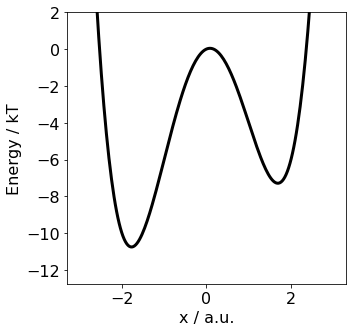

In [16]:
params = DoubleWell.params_default.copy()
params['dim'] = 2
double_well = DoubleWell(params=params)
plt.figure(figsize=(5,5))
double_well.plot_dimer_energy();
plt.savefig(paper_dir + 'figs/double_well/potential.pdf', bbox_inches='tight')

In [17]:
def plot_potential(cbar=True, orientation='vertical', figsize=(4, 5.5)):
    # 2D potential
    xgrid = np.linspace(-3, 3, 100)
    ygrid = np.linspace(-7, 7, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten()]).T
    E = double_well.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    plt.figure(figsize=figsize)
    plt.contourf(Xgrid, Ygrid, E, 50, cmap='jet', vmax=4)
    if cbar:
        if orientation == 'horizontal':
            cbar = plt.colorbar(orientation='horizontal', shrink=0.3, aspect=10, anchor=(0.5, 7.5), use_gridspec=False)#, anchor=(0, 0.5))
            cbar.outline.set_linewidth(1)
            cbar.outline.set_color('white')
            cbar.outline.fill = False
            plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='w')
            cbar.ax.xaxis.set_tick_params(color='white')
            #cbar.set_label('Energy / kT', labelpad=0, y=0.0, color='white')
        else:
            cbar = plt.colorbar()
            cbar.set_label('Energy / kT', labelpad=-15, y=0.6)
        cbar.set_ticks([-10, 0, 10])
    plt.xticks([-2, 0, 2])
    plt.yticks([-5, 0, 5])
    plt.xlabel('$x_1$', labelpad=0)
    plt.ylabel('$x_2$', labelpad=-10)

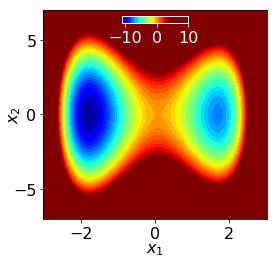

In [18]:
plot_potential(orientation='horizontal')
#plt.savefig(paper_dir + 'figs/double_well/potential2D_horizontal.pdf', bbox_inches='tight')

In [19]:
# simulation data
from deep_boltzmann.sampling import MetropolisGauss

In [20]:
nsteps = 10000
x0_left = np.array([[-1.8, 0.0]])
x0_right = np.array([[1.8, 0.0]])

sampler = MetropolisGauss(double_well, x0_left, noise=0.1, stride=10)
sampler.run(nsteps)
traj_left = sampler.traj.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.traj.copy()

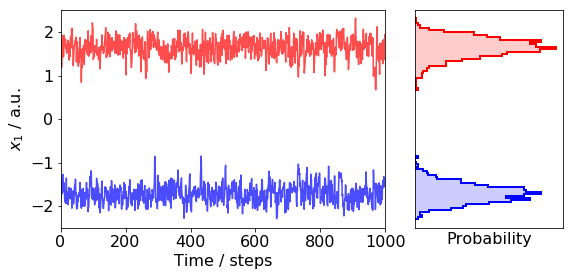

In [21]:
plt.figure(figsize=(9, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(traj_left[:, 0], color='blue', alpha=0.7)
ax1.plot(traj_right[:, 0], color='red', alpha=0.7)
ax1.set_xlim(0, 1000)
ax1.set_ylim(-2.5, 2.5)
ax1.set_xlabel('Time / steps')
ax1.set_ylabel('$x_1$ / a.u.')
ax2.hist(traj_left[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='blue', alpha=0.2);
ax2.hist(traj_left[:, 0], 30, orientation='horizontal', histtype='step', color='blue', linewidth=2);
ax2.hist(traj_right[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='red', alpha=0.2);
ax2.hist(traj_right[:, 0], 30, orientation='horizontal', histtype='step', color='red', linewidth=2);
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(-2.5, 2.5)
ax2.set_xlabel('Probability')
plt.savefig(paper_dir + 'figs/double_well/prior_trajs.pdf', bbox_inches='tight')

In [22]:
x = np.vstack([traj_left, traj_right])
xval = np.vstack([traj_left_val, traj_right_val])

In [23]:
# prepare transition state
x_ts = np.vstack([np.zeros(1000), (1.0/double_well.params['k']) * np.random.randn(1000)]).T

Estimate transition rate
----

In [24]:
params

{'a1': 1.0, 'a2': 6.0, 'a4': 1.0, 'dim': 2, 'k': 1.0}

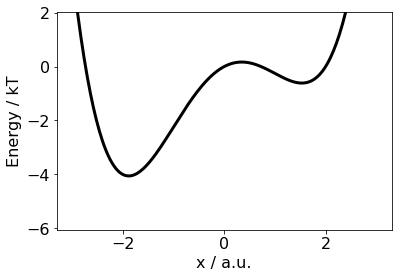

In [25]:
# change barrier but keep a/b
params_flat = params.copy()
params_flat['a2'] = 1.5
params_flat['a4'] = 0.25
double_well_flat = DoubleWell(params=params_flat)
double_well_flat.plot_dimer_energy();
#double_well_flat.plot_dimer_energy();

In [167]:
sampler = MetropolisGauss(double_well_flat, x0_left, noise=0.1, stride=100)
nstep = 1000000
sampler.run(nstep)

In [168]:
barrier_double_well = double_well.energy(np.array([[0, 0]])) - double_well.energy(np.array([[-2, 0]]))
barrier_double_well_flat = double_well_flat.energy(np.array([[0, 0]])) - double_well_flat.energy(np.array([[-2, 0]]))

In [171]:
from deep_boltzmann.util import count_transitions
Ntrans_low_barrier = count_transitions(sampler.traj[:, 0], -1, 1)
rate_low_barrier = float(Ntrans_low_barrier) / float(nstep)
dE = barrier_double_well - barrier_double_well_flat
rate_high_barrier = rate_low_barrier * np.exp(-dE)
print(1.0/rate_high_barrier)
#plt.plot(sampler.traj[:, 0])

[4034287.93492735]


Training
-------

In [24]:
epochsZ = 200
epochsE = 500
batchsize_ML = 128
batchsize_KL = 1000
temperature = 1.0
explore = 1.0

Networks
----

In [26]:
network_NICER_KLML = invnet(double_well.dim, 'NNNNS', double_well, nl_layers=3, nl_hidden=100, 
                            nl_activation='relu', nl_activation_scale='tanh')

<NNNN>S
< 2 0 0
N 1 1 0
N 1 1 0
N 1 1 0
N 1 1 0
> 1 1 0
S 2 0 0
Instructions for updating:
Colocations handled automatically by placer.


In [27]:
hist_NICER_KLML1 = network_NICER_KLML.train_ML(x, xval=xval, epochs=epochsZ, batch_size=batchsize_ML, std=1.0, 
                                               verbose=0, return_test_energies=True)
hist_NICER_KLML2 = network_NICER_KLML.train_flexible(x, xval=xval, lr=0.001, epochs=epochsE, batch_size=batchsize_KL, 
                                                     std=1.0,
                                                     weight_ML=1.0, weight_KL=1.0, weight_MC=0.0, weight_W2=0.0,
                                                     weight_RCEnt=0.0, rc_func=getx, rc_min=-2.5, rc_max=2.5,
                                                     temperature=temperature, explore=explore, verbose=0,
                                                     return_test_energies=True)

Instructions for updating:
Use tf.cast instead.


(<matplotlib.figure.Figure at 0x186044a2b0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x186040a4e0>,
       dtype=object))

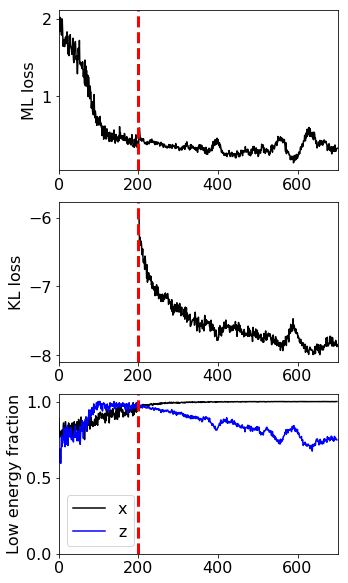

In [301]:
plot_convergence(hist_NICER_KLML1, hist_NICER_KLML2, 0, 2)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log
/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.5788833357194068


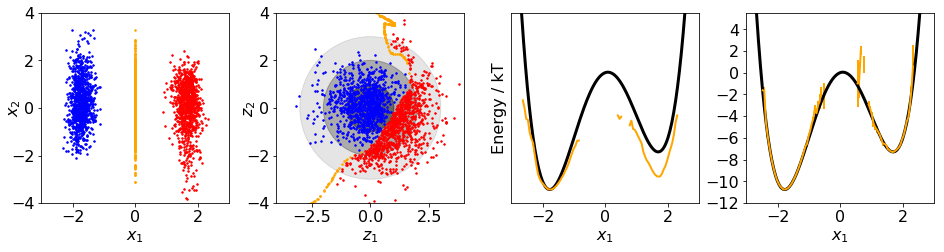

In [51]:
fig, axes = plot_network(network_NICER_KLML, weight_cutoff=1e-2);
#fig.savefig(paper_dir + 'figs/double_well/network_NICER_KLML.pdf', bbox_inches='tight')

In [29]:
network_RNVP_KLML = invnet(double_well.dim, 'RRRR', double_well, nl_layers=3, nl_hidden=100, 
                           nl_activation='relu', nl_activation_scale='tanh')

<RRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [30]:
hist_RNVP_KLML1 = network_RNVP_KLML.train_ML(x, xval=xval, epochs=epochsZ, batch_size=batchsize_ML, std=1.0, verbose=0,
                                             return_test_energies=True)
hist_RNVP_KLML2 = network_RNVP_KLML.train_flexible(x, xval=xval, lr=0.001, epochs=epochsE, batch_size=batchsize_KL, 
                                                   std=1.0,
                                                   weight_ML=1.0, weight_KL=1.0, weight_MC=0.0, weight_W2=0.0,
                                                   weight_RCEnt=0.0, rc_func=getx, rc_min=-2.5, rc_max=2.5,
                                                   temperature=temperature, explore=explore, verbose=0,
                                                   return_test_energies=True)

In [32]:
def energy_cut_z(ndim, nstd=3):
    z = np.random.randn(10000, ndim)
    zener = 0.5 * np.sum(z**2, axis=1)
    #return zener
    std = np.sqrt(np.mean((zener - zener.mean())**2))
    return zener.mean() + nstd*std

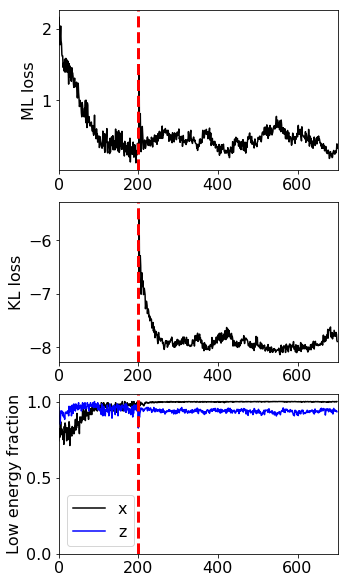

In [37]:
zcut = energy_cut_z(double_well.dim, nstd=3)
plot_convergence(hist_RNVP_KLML1, hist_RNVP_KLML2, 0, zcut)
#plt.savefig(paper_dir + 'figs/double_well/training_convergence_KLML.pdf', bbox_inches='tight', transparent=True)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log
/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.8032926267098387


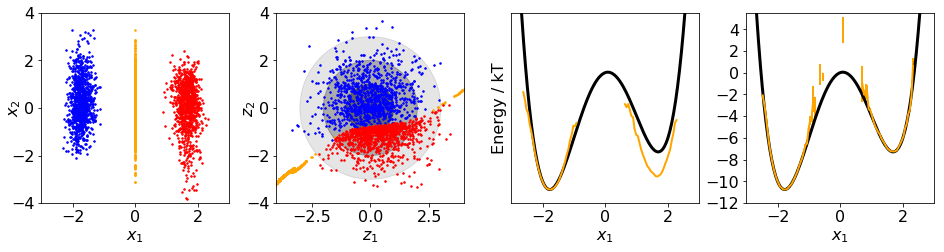

In [38]:
fig, axes = plot_network(network_RNVP_KLML, weight_cutoff=1e-2);
#fig.savefig(paper_dir + 'figs/double_well/network_RNVP_KLML.pdf', bbox_inches='tight')

In [30]:
network_NICER_KLRC = invnet(double_well.dim, 'NNNNS', double_well, nl_layers=3, nl_hidden=100, 
                            nl_activation='relu', nl_activation_scale='tanh')

<NNNN>S
< 2 0 0
N 1 1 0
N 1 1 0
N 1 1 0
N 1 1 0
> 1 1 0
S 2 0 0


In [31]:
hist_NICER_KLRC1 = network_NICER_KLRC.train_ML(x, xval=xval, epochs=epochsZ, batch_size=128, std=1.0, verbose=0, 
                                               return_test_energies=True)

In [32]:
hist_NICER_KLRC2 = network_NICER_KLRC.train_flexible(x, xval=xval, lr=0.001, epochs=epochsE, batch_size=2048, std=1.0,
                                                     weight_ML=0.01, weight_KL=1.0, weight_MC=0.0, weight_W2=0.0,
                                                     weight_RCEnt=1.0, rc_func=getx, rc_min=-2.5, rc_max=2.5,
                                                     temperature=temperature, explore=explore, verbose=0,
                                                     return_test_energies=True)

/Users/noe/anaconda/lib/python3.5/site-packages/keras/engine/topology.py:1539: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'scaling_xz_2/mul:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'index_layer_18/GatherV2:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'index_layer_18/GatherV2:0' shape=(?, 2) dtype=float32>]
  ' Found: ' + str(self.outputs))


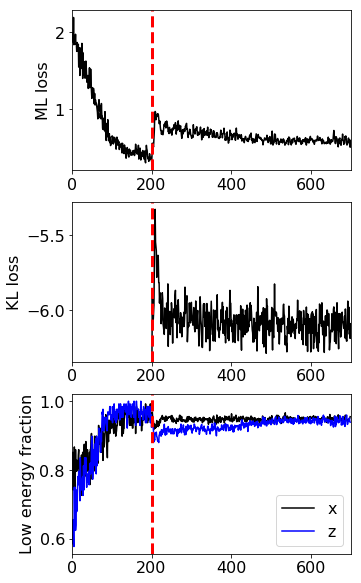

In [292]:
plot_convergence(hist_NICER_KLRC1, hist_NICER_KLRC2, 0, 2)

Estimator Standard Error:  0.08795844044358779


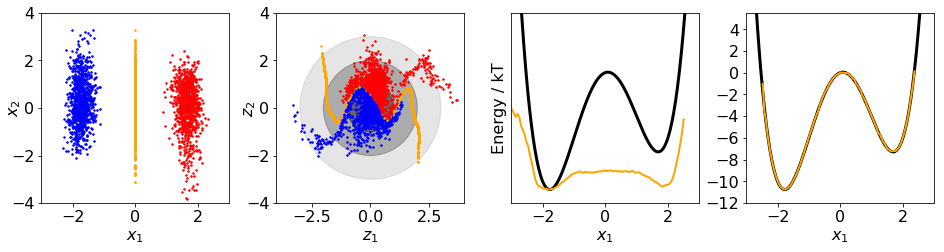

In [61]:
fig, axes = plot_network(network_NICER_KLRC, weight_cutoff=1e-2);
#fig.savefig(paper_dir + 'figs/double_well/network_NICER_KLRC.pdf', bbox_inches='tight')

In [25]:
network_RNVP_KLRC = invnet(double_well.dim, 'RRRR', double_well, nl_layers=3, nl_hidden=100, 
                            nl_activation='relu', nl_activation_scale='tanh')

<RRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0
Instructions for updating:
Colocations handled automatically by placer.


In [26]:
hist_RNVP_KLRC1 = network_RNVP_KLRC.train_ML(x, xval=xval, epochs=epochsZ, batch_size=batchsize_ML, std=1.0, verbose=0,
                                             return_test_energies=True)
hist_RNVP_KLRC2 = network_RNVP_KLRC.train_flexible(x, xval=xval, lr=0.001, epochs=epochsE, batch_size=batchsize_KL, 
                                                   std=1.0,
                                                   weight_ML=0.01, weight_KL=1.0, weight_MC=0.0, weight_W2=0.0,
                                                   weight_RCEnt=1.0, rc_func=getx, rc_min=-2.5, rc_max=2.5,
                                                   temperature=temperature, explore=explore, verbose=0,
                                                   return_test_energies=True)

Instructions for updating:
Use tf.cast instead.


/Users/noe/anaconda/lib/python3.5/site-packages/keras/engine/topology.py:1539: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'index_layer_3/GatherV2:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'index_layer_6/GatherV2:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'index_layer_6/GatherV2:0' shape=(?, 2) dtype=float32>]
  ' Found: ' + str(self.outputs))


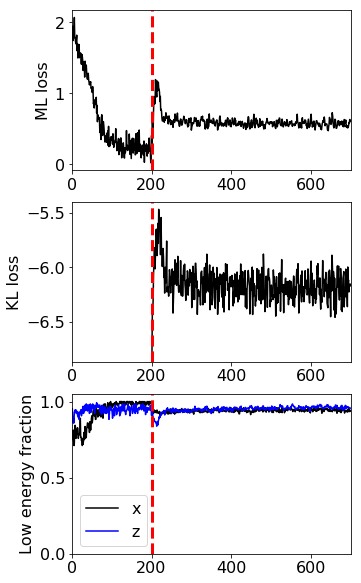

In [38]:
zcut = energy_cut_z(double_well.dim, nstd=3)
plot_convergence(hist_RNVP_KLRC1, hist_RNVP_KLRC2, 0, zcut)
#plt.savefig(paper_dir + 'figs/double_well/training_convergence_KLRC.pdf', bbox_inches='tight', transparent=True)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


Estimator Standard Error:  0.08949660686365932


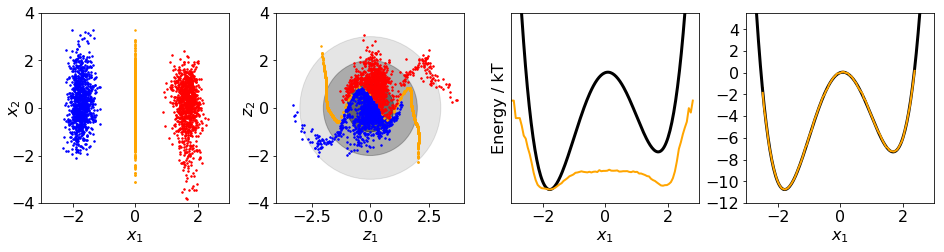

In [64]:
fig, axes = plot_network(network_NICER_KLRC, weight_cutoff=1e-2);
#fig.savefig(paper_dir + 'figs/double_well/network_RNVP_KLRC.pdf', bbox_inches='tight')

**Save Figures**

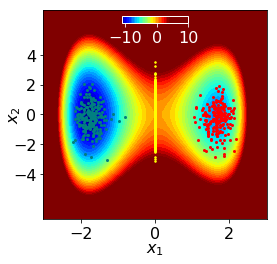

In [66]:
plot_potential(cbar=True, orientation='horizontal')
#plt.savefig(paper_dir + 'figs/double_well/potential2D_horizontal.pdf', bbox_inches='tight')
#plot_potential(cbar=True)
plt.plot(traj_left[::5, 0], traj_left[::5, 1], linewidth=0, marker='.', markersize=4, color='teal')
plt.plot(x_ts[:, 0], x_ts[:, 1], linewidth=0, marker='.', markersize=3, color='yellow')
plt.plot(traj_right[::5, 0], traj_right[::5, 1], linewidth=0, marker='.', markersize=4, color='red')
plt.xlabel('$x_1$')
#plt.xlim(-3, 3)
plt.ylabel('$x_2$')
#plt.ylim(-4, 4)
plt.yticks([-4, -2, 0, 2, 4]);
#plt.savefig(paper_dir + 'figs/double_well/xdist.pdf', bbox_inches='tight', transparent=True)

In [ ]:
z_left = network_NICER_KLRC.transform_xz(traj_left)
z_ts = network_NICER_KLRC.transform_xz(x_ts)
z_right = network_NICER_KLRC.transform_xz(traj_right)
plt.figure(figsize=(4, 4))
plt.plot(z_left[:, 0], z_left[:, 1], linewidth=0, marker='.', markersize=3, color='blue')
plt.plot(z_ts[:, 0], z_ts[:, 1], linewidth=0, marker='.', markersize=3, color='orange')
plt.plot(z_right[:, 0], z_right[:, 1], linewidth=0, marker='.', markersize=3, color='red')
circle = plt.Circle((0, 0), radius=1.0, color='black', alpha=0.4, fill=True)
plt.gca().add_artist(circle)
circle = plt.Circle((0, 0), radius=2.0, color='black', alpha=0.25, fill=True)
plt.gca().add_artist(circle)
circle = plt.Circle((0, 0), radius=3.0, color='black', alpha=0.1, fill=True)
plt.gca().add_artist(circle)
plt.xlabel('$z_1$')
plt.xlim(-4, 4)
plt.ylabel('$z_2$')
plt.ylim(-4, 4)
plt.yticks([-4, -2, 0, 2, 4]);
#plt.savefig(paper_dir + 'figs/double_well/zdist_NICER.pdf', bbox_inches='tight')

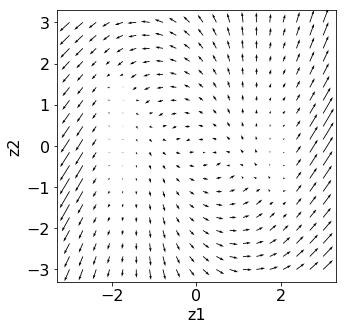

In [67]:
plot_transformation_field_2d(network_NICER_KLRC.Txz, [-3, 3, -3, 3], ngrid=20)
plt.xlabel('z1');
plt.ylabel('z2');

In [68]:
X1, Y1 = test_sample(network_NICER_KLML, temperature=1.0, plot=False);
X2, Y2 = test_sample(network_NICER_KLRC, temperature=1.0, plot=False);

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


In [36]:
nsample=100000

In [37]:
_, sample_x1, _, energy_x1, _ = network_NICER_KLML.sample(temperature=temperature, nsample=nsample)
_, sample_x2, _, energy_x2, _ = network_NICER_KLRC.sample(temperature=temperature, nsample=nsample)

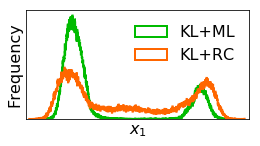

In [44]:
plt.figure(figsize=(4,2))
nsample = 100000
plt.hist(sample_x1[:, 0], 1000, histtype='step', color='#00BB00', linewidth=2, label='KL+ML');
plt.hist(sample_x2[:, 0], 1000, histtype='step', color='#FF6600', linewidth=2, label='KL+RC');
plt.xlim(-3, 3)
plt.yticks([]);
plt.xlabel('$x_1$')
plt.ylabel('Frequency')
plt.xticks([]);
plt.legend(ncol=1, loc='upper right', frameon=False)
#plt.savefig(paper_dir + 'figs/double_well/hist_samplex.pdf', bbox_inches='tight', transparent=True)

In [45]:
nsteps = 100000
sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_ref = sampler.traj.copy()
sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_ref = sampler.traj.copy()
x_ref = np.vstack([traj_left_ref, traj_right_ref])

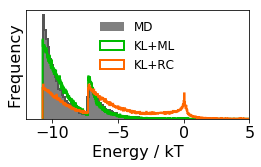

In [46]:
plt.figure(figsize=(4, 2))
nsample = 100000
energy_md = double_well.energy(x_ref)
plt.hist(energy_md, 100, density=True, color='grey', linewidth=1, label='MD');
plt.hist(energy_md, 100, density=True, histtype='step', color='#555555', linewidth=2);
plt.hist(energy_x1, 1000, density=True, histtype='step', color='#00BB00', linewidth=2, label='KL+ML');
plt.hist(energy_x2, 1000, density=True, histtype='step', color='#FF6600', linewidth=2, label='KL+RC');
plt.xlim(-12, 5)
plt.yticks([]);
plt.xlabel('Energy / kT')
plt.ylabel('Frequency')
plt.legend(ncol=1, loc=9, fontsize=12, frameon=False)
#plt.savefig(paper_dir + 'figs/double_well/hist_sample_energy.pdf', bbox_inches='tight', transparent=True)

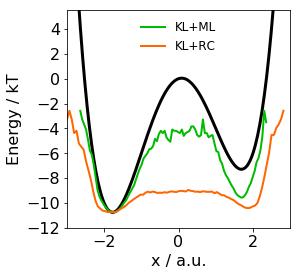

In [69]:
plt.figure(figsize=(4,4))
Ex, E = double_well.plot_dimer_energy(temperature=1.0)
Y1 = Y1 - Y1.min() + E.min()
Y2 = Y2 - Y2.min() + E.min()
plt.plot(X1, Y1, color='#00BB00', linewidth=2, label='KL+ML')
plt.plot(X2, Y2, color='#FF6600', linewidth=2, label='KL+RC')
plt.xlim(-3, 3)
plt.ylim(-12, 5.5)
plt.yticks([-12, -10, -8, -6, -4, -2, 0, 2, 4]);
plt.legend(ncol=1, loc=9, fontsize=12, frameon=False)
#plt.savefig(paper_dir + 'figs/double_well/energy_px.pdf', bbox_inches='tight')

In [48]:
RX1, RY1, DR1 = test_sample_rew(network_NICER_KLML, temperature=1.0, plot=False);
RX2, RY2, DR2 = test_sample_rew(network_NICER_KLRC, temperature=1.0, plot=False);

/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.7734511581636305
Estimator Standard Error:  0.05047526941784362


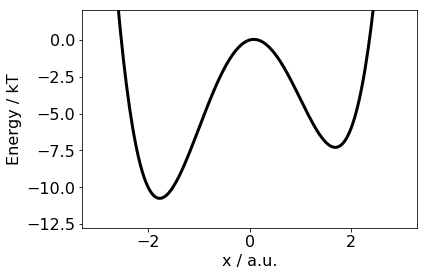

In [50]:
Ex, E = double_well.plot_dimer_energy(temperature=1.0)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater


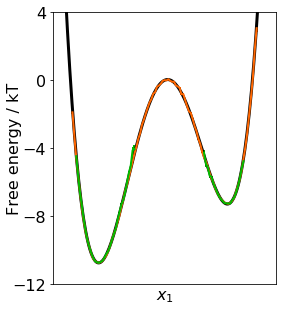

In [56]:
#test_sample_rew(network_NICER_KLRC, temperature=1.0);
plt.figure(figsize=(4, 5))
plt.plot(Ex, E, linewidth=3, color='black')
RY1 = RY1 - RY1[np.isfinite(RY1)].min() + E.min()
RY1[RY1 > -4] = np.nan
RY2 = RY2 - RY2[np.isfinite(RY2)].min() + E.min()
plt.errorbar(RX2, RY2, DR2, color='#FF6600', linewidth=2, label='ML+KL+RC')
plt.errorbar(RX1, RY1, DR1, color='#00BB00', linewidth=2, label='ML+KL')
plt.xlim(-3, 3)
plt.ylim(-12, 4)
#plt.yticks([-12, -10, -8, -6, -4, -2, 0, 2, 4]);
plt.yticks([-12, -8, -4, 0, 4]);
plt.xticks([]);
plt.xlabel('$x_1$')
plt.ylabel('Free energy / kT', labelpad=-10)
#plt.savefig(paper_dir + 'figs/double_well/free_energy_rew.pdf', bbox_inches='tight', transparent=True)

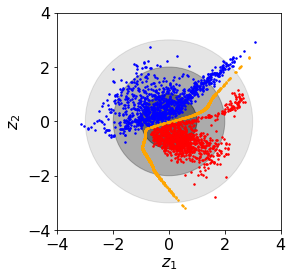

In [30]:
z_left = network_RNVP_KLRC.transform_xz(traj_left)
z_ts = network_RNVP_KLRC.transform_xz(x_ts)
z_right = network_RNVP_KLRC.transform_xz(traj_right)
plt.figure(figsize=(4, 4))
plt.plot(z_left[:, 0], z_left[:, 1], linewidth=0, marker='.', markersize=3, color='blue')
plt.plot(z_ts[:, 0], z_ts[:, 1], linewidth=0, marker='.', markersize=3, color='orange')
plt.plot(z_right[:, 0], z_right[:, 1], linewidth=0, marker='.', markersize=3, color='red')
circle = plt.Circle((0, 0), radius=1.0, color='black', alpha=0.4, fill=True)
plt.gca().add_artist(circle)
circle = plt.Circle((0, 0), radius=2.0, color='black', alpha=0.25, fill=True)
plt.gca().add_artist(circle)
circle = plt.Circle((0, 0), radius=3.0, color='black', alpha=0.1, fill=True)
plt.gca().add_artist(circle)
plt.xlabel('$z_1$')
plt.xlim(-4, 4)
plt.ylabel('$z_2$')
plt.ylim(-4, 4)
plt.yticks([-4, -2, 0, 2, 4]);
#plt.savefig(paper_dir + 'figs/double_well/zdist_realNVP.pdf', bbox_inches='tight', transparent=True)

In [57]:
def latent_interpolation(bg, x1, x2, nstep=1000):
    lambdas = np.array([np.linspace(0, 1, num=nstep)]).T
    x1 = np.array([x1])
    x2 = np.array([x2])
    z1 = bg.transform_xz(x1)
    z2 = bg.transform_xz(x2)
    zpath = z1 + lambdas*(z2-z1)
    xpath = bg.transform_zx(zpath)
    return xpath

In [58]:
xpaths = []
for i in range(10):
    x1 = traj_left[np.random.randint(1000)] 
    x2 = traj_right[np.random.randint(1000)]
    xpaths.append(latent_interpolation(network_RNVP_KLRC, x1, x2, nstep=1000))

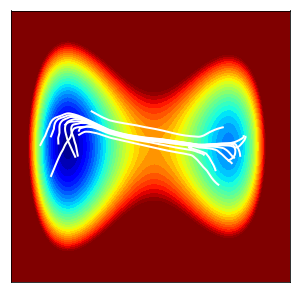

In [64]:
plot_potential(cbar=False, figsize=(5, 5))
plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('')
for xpath in xpaths:
    plt.plot(xpath[:, 0], xpath[:, 1], linewidth=2, color='white')
#plt.savefig(paper_dir + 'figs/double_well/paths.pdf', bbox_inches='tight', transparent=True)